In [1]:
# ------------------------
# ---- import libraries
# ------------------------
import os,sys
import numpy as np
# xarray
import xarray as xr
# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib.colors import Colormap
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cmocean as ccm


In [2]:
from dask.distributed import Client
c = Client()
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46673 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46673/status,
Dashboard: http://127.0.0.1:46673/status,Workers: 8
Total threads: 40,Total memory: 188.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38269,Workers: 8
Dashboard: http://127.0.0.1:46673/status,Total threads: 40
Started: Just now,Total memory: 188.15 GiB
Comm: tcp://127.0.0.1:36633,Total threads: 5
Dashboard: http://127.0.0.1:43457/status,Memory: 23.52 GiB
Nanny: tcp://127.0.0.1:43095,


In [3]:
def vectorize(cs):
    """
    Vectorize contourf plots to reduce weight of figures saved as PDFs.
    """
    for c in cs.collections:
        c.set_rasterized(True)

# loading data

In [4]:
y1='2005'
y2='2018'
chunk_size = {"x":133,"y":320}
# plot directory
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

In [5]:
# read grid files
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask.isel(nav_lev=0)

diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
nav_lon = mesh_hgr.nav_lon
nav_lat = mesh_hgr.nav_lat
mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0) # grille lat/lon

BGRmask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc').BGRmask.squeeze()
# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70

#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831


In [6]:
#========= Plot settings ===============
# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
cmap = cm.RdYlBu_r
my_map1 = truncate_colormap(cmap)
colors = my_map1(np.linspace(0., 1, 50))
mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

lmin = -10.0
incr = 1
lmax = lmin*(-1)+0.1
# define the bins and normalize
bounds = np.arange(lmin,lmax,incr)
norm = mcolors.BoundaryNorm(bounds, mycm.N)

In [8]:
# significance threshold
# pval = 0.05
# pval = 0.32
pval = 0.10
alphaHatch = 0.05

## SLA

In [9]:
ds_slaGAI = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/SSH/GAI/eORCA025.L75-IMHOTEP._y2005_2018.1y_trendGAI_linregress.nc').linregress

In [10]:
# p-value
sla_pval_GAI = ds_slaGAI.sel(parameter='pvalue')
# slope
slaTrGAI = ds_slaGAI.sel(parameter='slope')

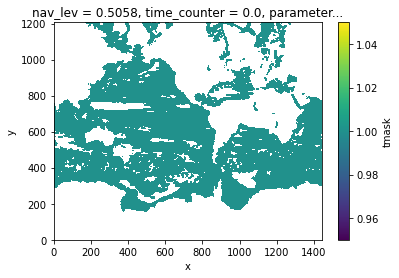

In [10]:
sla_TrGAI_signi = tmask.where(sla_pval_GAI>pval)

sla_TrGAI_signi.where(sla_TrGAI_signi==1).plot()

### get the mean of the trend in the BGR box

In [11]:
# ------ mesh for constructing the weight for the computation of the global mean sea level
# chunk_size2 = {"x":133,"y":320}
chunk_size = {"member":1,"x":500,"y":500}

diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask

e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

nav_lon =  mesh_hgr.nav_lon
nav_lat =  mesh_hgr.nav_lat

# constructing the weight
bt = (e1t * e2t).load()# area of each cell

In [14]:
slaTrGAI_BGR = slaTrGAI.where(BGRmask,drop=True)

# selecting the Beaufort Gyre box and doing the weighted mean over the box

btboxBG = bt.where(BGRmask,drop=True)
tmaskboxBG = tmask.where(BGRmask,drop=True)
oceanArea = (btboxBG*tmaskboxBG[0])  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
WeightboxBG = (oceanArea/totalOceanArea) #.compute()

slaTrGAI_BGRmean =(slaTrGAI_BGR * WeightboxBG).sum(('x','y'))

In [15]:
slaTrGAI_BGRmean.values

array(15.10034642)

In [17]:
(1.47/15.1)*100

9.735099337748345

# decomposition

In [11]:
pathuna12nf= "/gpfswork/rech/cli/uor98hu/MYDATA/SLdecomposition_WP1/una12nf/"

## steric

In [12]:
decomp = "steric" 
ds_steGAI = xr.open_dataset(pathuna12nf+'eORCA025.L75-IMHOTEP._y2005_2018.1y_'+decomp+'_0_bottom_trendGAI_linregress.nc').linregress

# p-value
ste_pval_GAI = ds_steGAI.sel(parameter='pvalue')

# slope
steTrGAI = ds_steGAI.sel(parameter='slope')

ste_TrGAI_signi = tmask.where(ste_pval_GAI>pval)


## mano

In [13]:
manTrGAI  = slaTrGAI  - steTrGAI


## halosteric

In [14]:
decomp = "halosteric" 
ds_halGAI = xr.open_dataset(pathuna12nf+'eORCA025.L75-IMHOTEP._y2005_2018.1y_'+decomp+'_0_bottom_trendGAI_linregress.nc').linregress

# p-value
hal_pval_GAI = ds_halGAI.sel(parameter='pvalue')

# slope
halTrGAI = ds_halGAI.sel(parameter='slope')

hal_TrGAI_signi = tmask.where(hal_pval_GAI>pval)


## thermo

In [15]:
decomp = "thermosteric" 
ds_theGAI = xr.open_dataset(pathuna12nf+'eORCA025.L75-IMHOTEP._y2005_2018.1y_'+decomp+'_0_bottom_trendGAI_linregress.nc').linregress

# p-value
the_pval_GAI = ds_theGAI.sel(parameter='pvalue')

# slope
theTrGAI = ds_theGAI.sel(parameter='slope')

the_TrGAI_signi = tmask.where(the_pval_GAI>pval)

# plot figure 4 review

In [16]:
cmap = cm.RdYlBu_r
my_map1 = truncate_colormap(cmap)
colors = my_map1(np.linspace(0., 1, 50))
mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

lmin = -20.0
incr = 1
lmax = lmin*(-1)+0.1
# define the bins and normalize
bounds = np.arange(lmin,lmax,incr*2)

norm_SLA = mcolors.BoundaryNorm(bounds, mycm.N)

In [36]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, axa = plt.subplots(1, 1,figsize=(10,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})

#----------------- SLA part--------------------------------------
# ========GAI
data2plot = (slaTrGAI).where(tmask!=0,0).squeeze()
axa.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm_SLA)
# significance
cs2_2= axa.contourf(nav_lon, nav_lat, sla_TrGAI_signi.where(sla_TrGAI_signi==1).where(nav_lon>0),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_2)

cs2_1= axa.contourf(nav_lon, nav_lat,sla_TrGAI_signi.where(sla_TrGAI_signi==1).where(nav_lon<0),transform=trdata, \
                  colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_1)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axa.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axa.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axa.set_title("a. SLA", fontsize=24) 

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='both', ticks=bounds, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Trends over '+y1+'-'+y2+r' [$mm$ $yr^{-1}$]', fontsize=24)
## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_SLA_GAI_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
# plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
plt.close(fig)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)

In [35]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, [(axd,axg),(axj,axm)] = plt.subplots(2, 2,figsize=(10,10),facecolor='none', \
                                                                             dpi=72*2,subplot_kw={'projection': proj})
plt.subplots_adjust(wspace=0, hspace=0.2)
# # gridspec_kw = {'wspace':0, 'hspace':0.1}

#----------------- steric part--------------------------------------
# ========GAI
data2plot = (steTrGAI).where(tmask!=0,0).squeeze()
axd.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axd.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm_SLA)
# significance
cs2_2= axd.contourf(nav_lon, nav_lat, ste_TrGAI_signi.where(ste_TrGAI_signi==1).where(nav_lon>0),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_2)

cs2_1= axd.contourf(nav_lon, nav_lat,ste_TrGAI_signi.where(ste_TrGAI_signi==1).where(nav_lon<0),transform=trdata, \
                  colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_1)

clr2 = axd.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axd.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axd.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axd.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axd.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axd.set_title("b. Steric", fontsize=24) 

#----------------- mano part--------------------------------------
# ========GAI
data2plot = (manTrGAI).where(tmask!=0,0).squeeze()
axg.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axg.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm_SLA)
# significance
cs2_2= axg.contourf(nav_lon, nav_lat, sla_TrGAI_signi.where(sla_TrGAI_signi==1).where(nav_lon>0),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_2)

cs2_1= axg.contourf(nav_lon, nav_lat,sla_TrGAI_signi.where(sla_TrGAI_signi==1).where(nav_lon<0),transform=trdata, \
                  colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_1)

clr2 = axg.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axg.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axg.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axg.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axg.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axg.set_title("c. Manometric", fontsize=24) 

#----------------- halo part--------------------------------------
# ========GAI
data2plot = (halTrGAI).where(tmask!=0,0).squeeze()
axj.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axj.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm_SLA)
# significance
cs2_2= axj.contourf(nav_lon, nav_lat, hal_TrGAI_signi.where(hal_TrGAI_signi==1).where(nav_lon>0),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_2)

cs2_1= axj.contourf(nav_lon, nav_lat,hal_TrGAI_signi.where(hal_TrGAI_signi==1).where(nav_lon<0),transform=trdata, \
                  colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_1)

clr2 = axj.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axj.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axj.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axj.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axj.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axj.set_title("d. Halosteric", fontsize=24) 


#----------------- thermo part--------------------------------------
# ========GAI
data2plot = (theTrGAI).where(tmask!=0,0).squeeze()
axm.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axm.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm_SLA)
# significance
cs2_2= axm.contourf(nav_lon, nav_lat, the_TrGAI_signi.where(the_TrGAI_signi==1).where(nav_lon>0),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_2)

cs2_1= axm.contourf(nav_lon, nav_lat,the_TrGAI_signi.where(the_TrGAI_signi==1).where(nav_lon<0),transform=trdata, \
                  colors='none',alpha=alphaHatch,hatches=['...'*1, '/'], add_colorbar=False)
vectorize(cs2_1)

clr2 = axm.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axm.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axm.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axm.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axm.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axm.set_title("e. Thermosteric", fontsize=24) 



namo="maps_signi010_GAI_decomposition_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
# plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
plt.close(fig)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)

# maps sans la significance

In [28]:
trdata  = ccrs.PlateCarree() 
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, [(axa,axb,axc),(axd,axe,axf),(axg,axh,axi),(axj,axk,axl),(axm,axn,axo)] = plt.subplots(5, 3,figsize=(19,30),facecolor='none', \
                                                                             dpi=72*2,subplot_kw={'projection': proj})
plt.subplots_adjust(wspace=0, hspace=0.1)
# gridspec_kw = {'wspace':0, 'hspace':0.1}

axa.text(-0.02, 0.98, 'a)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axa.transAxes)
axb.text(-0.02, 0.98, 'b)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axb.transAxes)
axc.text(-0.02, 0.98, 'c)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axc.transAxes)
axd.text(-0.02, 0.98, 'd)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axd.transAxes)
axe.text(-0.02, 0.98, 'e)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axe.transAxes)
axf.text(-0.02, 0.98, 'f)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axf.transAxes)
axg.text(-0.02, 0.98, 'g)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axg.transAxes)
axh.text(-0.02, 0.98, 'h)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axh.transAxes)
axi.text(-0.02, 0.98, 'i)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axi.transAxes)
axj.text(-0.02, 0.98, 'j)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axj.transAxes)
axk.text(-0.02, 0.98, 'k)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axk.transAxes)
axl.text(-0.02, 0.98, 'l)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axl.transAxes)
axm.text(-0.02, 0.98, 'm)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axm.transAxes)
axn.text(-0.02, 0.98, 'n)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axn.transAxes)
axo.text(-0.02, 0.98, 'o)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axo.transAxes)

axa.text(-0.14, 0.5, 'SLA',          fontsize=24, horizontalalignment='center', verticalalignment='center',rotation='vertical', transform=axa.transAxes)
axd.text(-0.14, 0.5, 'Steric',       fontsize=24, horizontalalignment='center', verticalalignment='center',rotation='vertical', transform=axd.transAxes)
axg.text(-0.14, 0.5, 'Manometric',   fontsize=24, horizontalalignment='center', verticalalignment='center',rotation='vertical', transform=axg.transAxes)
axj.text(-0.14, 0.5, 'Halosteric',   fontsize=24, horizontalalignment='center', verticalalignment='center',rotation='vertical', transform=axj.transAxes)
axm.text(-0.14, 0.5, 'Thermosteric', fontsize=24, horizontalalignment='center', verticalalignment='center',rotation='vertical', transform=axm.transAxes)

#----------------- SLA part--------------------------------------
# ========GAI-S
data2plot = (slaTrGAI_S).where(tmask!=0,0).squeeze()
axa.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# # significance
# cs2_2= axa.contourf(nav_lon, nav_lat, sla_TrGAI_S_signi.where(sla_TrGAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axa.contourf(nav_lon, nav_lat,sla_TrGAI_S_signi.where(sla_TrGAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axa.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axa.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axa.set_title("Gr+Riv", fontsize=24) 

# ========GAI-AI
data2plot = (slaTrGAI_AI).where(tmask!=0,0).squeeze()
axb.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axb.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axb.contourf(nav_lon, nav_lat, sla_TrGAI_AI_signi.where(sla_TrGAI_AI_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axb.contourf(nav_lon, nav_lat,sla_TrGAI_AI_signi.where(sla_TrGAI_AI_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axb.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axb.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axb.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axb.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axb.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axb.set_title("GREENLAND", fontsize=24) 

# ========AI-S
data2plot = (slaTrAI_S).where(tmask!=0,0).squeeze()
axc.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axc.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axc.contourf(nav_lon, nav_lat, sla_TrAI_S_signi.where(sla_TrAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axc.contourf(nav_lon, nav_lat,sla_TrAI_S_signi.where(sla_TrAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axc.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axc.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axc.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axc.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axc.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

axc.set_title("RIVERS", fontsize=24) 

# cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=axc, cax = axc.inset_axes([1.1, 0, 0.05, 1.0]))
# # fig.colorbar(pcm, ax=ax, cax=cax))
# cbar.ax.tick_params(labelsize=10)
# cbar.set_label(r'SLA trends over '+y1+'-'+y2+' [mm/yr]', fontsize=14)


#----------------- steric part--------------------------------------
# ========GAI-S
data2plot = (steTrGAI_S).where(tmask!=0,0).squeeze()
axd.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axd.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axd.contourf(nav_lon, nav_lat, ste_TrGAI_S_signi.where(ste_TrGAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axd.contourf(nav_lon, nav_lat,ste_TrGAI_S_signi.where(ste_TrGAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axd.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axd.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axd.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axd.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axd.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# ========GAI-AI
data2plot = (steTrGAI_AI).where(tmask!=0,0).squeeze()
axe.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axe.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# # significance
# cs2_2= axe.contourf(nav_lon, nav_lat, ste_TrGAI_AI_signi.where(ste_TrGAI_AI_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axe.contourf(nav_lon, nav_lat,ste_TrGAI_AI_signi.where(ste_TrGAI_AI_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axe.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axe.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axe.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axe.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axe.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# ========AI-S
data2plot = (steTrAI_S).where(tmask!=0,0).squeeze()
axf.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axf.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axf.contourf(nav_lon, nav_lat, ste_TrAI_S_signi.where(ste_TrAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axf.contourf(nav_lon, nav_lat,ste_TrAI_S_signi.where(ste_TrAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axf.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axf.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axf.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axf.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axf.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=axf, cax = axf.inset_axes([1.1, 0, 0.05, 1.0]))
# # fig.colorbar(pcm, ax=ax, cax=cax))
# cbar.ax.tick_params(labelsize=10)
# cbar.set_label(r'Steric trends over '+y1+'-'+y2+' [mm/yr]', fontsize=14)

#----------------- mano part--------------------------------------
# ========GAI-S
data2plot = (manTrGAI_S).where(tmask!=0,0).squeeze()
axg.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axg.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axg.contourf(nav_lon, nav_lat, sla_TrGAI_S_signi.where(sla_TrGAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axg.contourf(nav_lon, nav_lat,sla_TrGAI_S_signi.where(sla_TrGAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axg.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axg.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axg.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axg.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axg.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# ========GAI-AI
data2plot = (manTrGAI_AI).where(tmask!=0,0).squeeze()
axh.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axh.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axh.contourf(nav_lon, nav_lat, sla_TrGAI_AI_signi.where(sla_TrGAI_AI_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axh.contourf(nav_lon, nav_lat,sla_TrGAI_AI_signi.where(sla_TrGAI_AI_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axh.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axh.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axh.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axh.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axh.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# ========AI-S
data2plot = (manTrAI_S).where(tmask!=0,0).squeeze()
axi.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axi.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axi.contourf(nav_lon, nav_lat, sla_TrAI_S_signi.where(sla_TrAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axi.contourf(nav_lon, nav_lat,sla_TrAI_S_signi.where(sla_TrAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axi.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axi.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axi.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axi.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axi.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=axi, cax = axi.inset_axes([1.1, 0, 0.05, 1.0]))
# # fig.colorbar(pcm, ax=ax, cax=cax))
# cbar.ax.tick_params(labelsize=10)
# cbar.set_label(r'Manometric trends over '+y1+'-'+y2+' [mm/yr]', fontsize=14)

#----------------- halo part--------------------------------------
# ========GAI-S
data2plot = (halTrGAI_S).where(tmask!=0,0).squeeze()
axj.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axj.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axj.contourf(nav_lon, nav_lat, hal_TrGAI_S_signi.where(hal_TrGAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axj.contourf(nav_lon, nav_lat,hal_TrGAI_S_signi.where(hal_TrGAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axj.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axj.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axj.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axj.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axj.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# ========GAI-AI
data2plot = (halTrGAI_AI).where(tmask!=0,0).squeeze()
axk.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axk.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axk.contourf(nav_lon, nav_lat, hal_TrGAI_AI_signi.where(hal_TrGAI_AI_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axk.contourf(nav_lon, nav_lat,hal_TrGAI_AI_signi.where(hal_TrGAI_AI_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axk.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axk.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axk.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axk.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axk.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# ========AI-S
data2plot = (halTrAI_S).where(tmask!=0,0).squeeze()
axl.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axl.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axl.contourf(nav_lon, nav_lat, hal_TrAI_S_signi.where(hal_TrAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axl.contourf(nav_lon, nav_lat,hal_TrAI_S_signi.where(hal_TrAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axl.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axl.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axl.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axl.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axl.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=axl, cax = axl.inset_axes([1.1, 0, 0.05, 1.0]))
# # fig.colorbar(pcm, ax=ax, cax=cax))
# cbar.ax.tick_params(labelsize=10)
# cbar.set_label(r'Halosteric trends over '+y1+'-'+y2+' [mm/yr]', fontsize=14)

#----------------- thermo part--------------------------------------
# ========GAI-S
data2plot = (theTrGAI_S).where(tmask!=0,0).squeeze()
axm.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axm.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# # significance
# cs2_2= axm.contourf(nav_lon, nav_lat, the_TrGAI_S_signi.where(the_TrGAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axm.contourf(nav_lon, nav_lat,the_TrGAI_S_signi.where(the_TrGAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axm.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axm.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axm.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axm.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axm.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# ========GAI-AI
data2plot = (theTrGAI_AI).where(tmask!=0,0).squeeze()
axn.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axn.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axn.contourf(nav_lon, nav_lat, the_TrGAI_AI_signi.where(the_TrGAI_AI_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axn.contourf(nav_lon, nav_lat,the_TrGAI_AI_signi.where(the_TrGAI_AI_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axn.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axn.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axn.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axn.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axn.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# ========AI-S
data2plot = (theTrAI_S).where(tmask!=0,0).squeeze()
axo.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axo.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm,transform=trdata,norm=norm)
# significance
# cs2_2= axo.contourf(nav_lon, nav_lat, the_TrAI_S_signi.where(the_TrAI_S_signi==1).where(nav_lon>0),transform=trdata, \
#                     colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_2)

# cs2_1= axo.contourf(nav_lon, nav_lat,the_TrAI_S_signi.where(the_TrAI_S_signi==1).where(nav_lon<0),transform=trdata, \
#                   colors='none',alpha=0.2,hatches=['...'*1, '/'], add_colorbar=False)
# vectorize(cs2_1)

clr2 = axo.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axo.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axo.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axo.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axo.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

fig.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.15, 0.16, 0.7, 0.01])  #(left, bottom, width, height)
cbar = fig.colorbar(cs,extend='both', ticks=bounds, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'Trends over '+y1+'-'+y2+r' [$mm yr^{-1}$]', fontsize=24)
# cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_nosigni_linregresstrends_4paperv3.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 
# plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
plt.close(fig)

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/gpfslocalsup/pub/anac